# Imports & Settings

In [1]:
# Core tools
import numpy as np
import pandas as pd

# Visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Modeling tools
import xgboost
from xgboost import XGBRegressor, XGBRFRegressor
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_theme()

# Baseline OLS Model
## Importing Data

In [3]:
df = pd.read_csv('../data/preprocessed_data/MSFT_preprocessed.csv')
df.head()

,Report Date,Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Research & Development,Operating Income (Loss),Non-Operating Income (Loss),"Pretax Income (Loss), Adj.",...,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,Price Date,Open,High,Low,Close,Adj Close,Volume
0,2009-06-30,1.309900e+10,-2.586000e+09,1.051300e+10,-6.816000e+09,-4.591000e+09,-2.225000e+09,3.697000e+09,155000000.0,3852000000,...,1.210000e+08,2.699000e+09,-1209000000,2009-06-30,23.969999,24.240000,23.629999,23.770000,18.209595,66452400.0
1,2009-09-30,1.292000e+10,-2.842000e+09,1.007800e+10,-5.596000e+09,-3.531000e+09,-2.065000e+09,4.482000e+09,283000000.0,4765000000,...,-1.292000e+09,-2.190000e+09,2747000000,2009-09-30,25.760000,25.990000,25.379999,25.719999,19.814228,63533400.0
2,2009-12-31,1.902200e+10,-3.628000e+09,1.539400e+10,-6.881000e+09,-4.802000e+09,-2.079000e+09,8.513000e+09,370000000.0,8883000000,...,-3.138000e+09,-4.277000e+09,599000000,2009-12-31,30.980000,30.990000,30.480000,30.480000,23.585039,31929700.0
3,2010-03-31,1.450300e+10,-2.755000e+09,1.174800e+10,-6.575000e+09,-4.355000e+09,-2.220000e+09,5.173000e+09,168000000.0,5341000000,...,-1.601000e+09,-2.726000e+09,-1267000000,2010-03-31,29.639999,29.719999,29.170000,29.290001,22.770212,63760000.0
4,2010-06-30,1.603900e+10,-3.170000e+09,1.286900e+10,-6.939000e+09,-4.589000e+09,-2.350000e+09,5.930000e+09,94000000.0,6024000000,...,-2.927000e+09,-4.098000e+09,-2650000000,2010-06-30,23.299999,23.680000,22.950001,23.010000,17.968822,81050500.0


## Dropping Columns
The two object columns (`Report Date` and `Price Date`) are not needed for modeling purposes. Additionally, the `Open`, `High`, `Low`, `Adj Close`, and `Volume` columns are highly correlated with the `Close` column. Dropping these columns are necessary for modeling purposes.

In [4]:
df = df.drop(columns=['Report Date', 'Price Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'])

## Fitting Model

In [5]:
def fit_model(df, target='Close'):
    '''
    Description:
    ------------
    Takes a dataframe and returns a fitted OLS model with price as the dependent variable.
    
    Parameters:
    ------------
    df : pandas.DataFrame
        This dataframe should include all of the predictors and the target column.
    
    target: str
        The name of the column being predicted (dependent variable).
    
    Example:
    ------------
    >>> fit_model(df)
    <statsmodels.regression.linear_model.RegressionResultsWrapper>
    '''
    predictors = df.drop(columns=[target])
    predictors = sm.add_constant(predictors)
    model = sm.OLS(df[target], predictors).fit()
    return model

baseline = fit_model(df)
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     66.11
Date:                Thu, 26 Aug 2021   Prob (F-statistic):           1.76e-05
Time:                        14:06:40   Log-Likelihood:                -93.237
No. Observations:                  42   AIC:                             258.5
Df Residuals:                       6   BIC:                             321.0
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                              66.8006    132.787      0.503      0.633    -258.118     391.720
Revenue                                             0.0053      0.011      0.503      0.633      -0.020       0.031
Cost of Revenue                                     0.0053      0.011      0.503      0.633      -0.020       0.031
Gross Profit                                       -0.0040      0.008     -0.503      0.633      -0.023       0.015
Operating Expenses                               2.976e-05   5.92e-05      0.503      0.633      -0.000       0.000
Selling, General & Administrative                   0.0013      0.003      0.503      0.633      -0.005       0.008
Research & Development                              0.0013      0.003      0.503      0.633      -0.005       0.008
Operating Income (Loss)                             0.0044      0.009      0.503      0.633      -0.017       0.026
Non-Operating Income (Loss)                         0.0057      0.011      0.503      0.633      -0.022       0.033
Pretax Income (Loss), Adj.                         -0.0057      0.011     -0.503      0.633      -0.033       0.022
Pretax Income (Loss)                               -0.0042      0.008     -0.503      0.633      -0.025       0.016
Income Tax (Expense) Benefit, Net                  -0.0042      0.008     -0.503      0.633      -0.025       0.016
Income (Loss) from Continuing Operations            0.0006      0.001      0.503      0.633      -0.002       0.004
Net Income                                          0.0035      0.007      0.503      0.633      -0.014       0.021
Net Income (Common)                                 0.0010      0.002      0.503      0.633      -0.004       0.006
Cash, Cash Equivalents & Short Term Investments -1.638e-09   3.19e-09     -0.514      0.626   -9.44e-09    6.16e-09
Accounts & Notes Receivable                      6.871e-10   4.07e-09      0.169      0.871   -9.27e-09    1.06e-08
Inventories                                     -1.615e-09   7.45e-09     -0.217      0.836   -1.98e-08    1.66e-08
Total Current Assets                                0.0030      0.006      0.503      0.633      -0.011       0.017
Property, Plant & Equipment, Net                    0.0001      0.000      0.503      0.633      -0.000       0.001
Long Term Investments & Receivables                 0.0001      0.000      0.503      0.633      -0.000       0.001
Other Long Term Assets                              0.0001      0.000      0.503      0.633      -0.000       0.001
Total Noncurrent Assets                             0.0029      0.006      0.503      0.633      -0.011       0.017
Total Assets                                        0.0054      0.0

## Evaluating Fitness

In [6]:
def print_rmse(df, target='Close', decimals=2):
    '''
    Description:
    ------------
    Takes a dataframe, splits it into train/test data, fits it to a linear regression model,
    then calculates and prints the RMSE for both the train and test portions rounded to two
    decimal places.
    
    Parameters:
    ------------
    df : pandas.DataFrame
        This dataframe should include all of the predictors and the target column.
    
    target: str
        The name of the column being predicted (dependent variable).
    
    decimals: int
        The number of decimals to round the output to.
    
    Example:
    ------------
    >>> print_rmse(df)
    Train RMSE: 100,000.00
    Test RMSE:  101,250.00
    '''
    X = df.drop(columns=[target])
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred_train = linreg.predict(X_train)
    y_pred_test = linreg.predict(X_test)
    
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    
    print('Train RMSE:', round(rmse_train, decimals))
    print('Test  RMSE:', round(rmse_test, decimals))
    
print_rmse(df)

Train RMSE: 0.0
Test  RMSE: 54.76


## Plotting Residuals

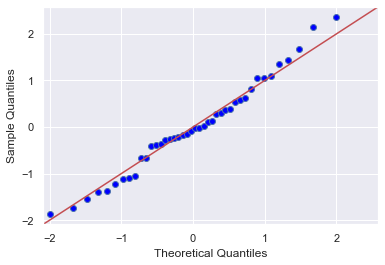

In [7]:
def qqplot(model):
    '''
    Description:
    ------------
    Takes an OLS model and returns a Q-Q plot of the model residuals.
    
    Parameters:
    ------------
    model : a fitted statsmodels.api.OLS() model
    
    Example:
    ------------
    >>> get_qqplot(model)
    <matplotlib.figure.Figure>
    '''
    return sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

qqplot(baseline);

## Observations
- The baseline model results are too good to be true (R^2 ~99.7%) as evidenced by the p-values of each of the independent variables
- The large condition number indicates that there's an issue with multicollinearity
- There are large scaling differences between the independent variables
- The model exhibits a large degree of overfitness based on the train and test RMSE values
- While the residuals are normally distributed, this model cannot be trusted

# Investigating Multicollinearity
## Correlation Matrix
Renaming the columns to shortened versions in order to increase the space available for the matrix squares:

In [42]:
df_temp = df.copy()
df_temp.columns = [col[:13]+'...' if len(col) > 15 else col for col in df.columns]
df_temp.columns

Index(['Revenue', 'Cost of Revenue', 'Gross Profit', 'Operating Exp...',
       'Selling, Gene...', 'Research & De...', 'Operating Inc...',
       'Non-Operating...', 'Pretax Income...', 'Pretax Income...',
       'Income Tax (E...', 'Income (Loss)...', 'Net Income',
       'Net Income (C...', 'Cash, Cash Eq...', 'Accounts & No...',
       'Inventories', 'Total Current...', 'Property, Pla...',
       'Long Term Inv...', 'Other Long Te...', 'Total Noncurr...',
       'Total Assets', 'Payables & Ac...', 'Short Term Debt',
       'Total Current...', 'Long Term Debt', 'Total Noncurr...',
       'Total Liabili...', 'Share Capital...', 'Retained Earn...',
       'Total Equity', 'Total Liabili...', 'Net Income/St...',
       'Depreciation ...', 'Non-Cash Items', 'Change in Wor...',
       'Change in Acc...', 'Change in Inv...', 'Change in Acc...',
       'Change in Other', 'Net Cash from...', 'Change in Fix...',
       'Net Change in...', 'Net Cash from...', 'Net Cash from...',
       'Divide

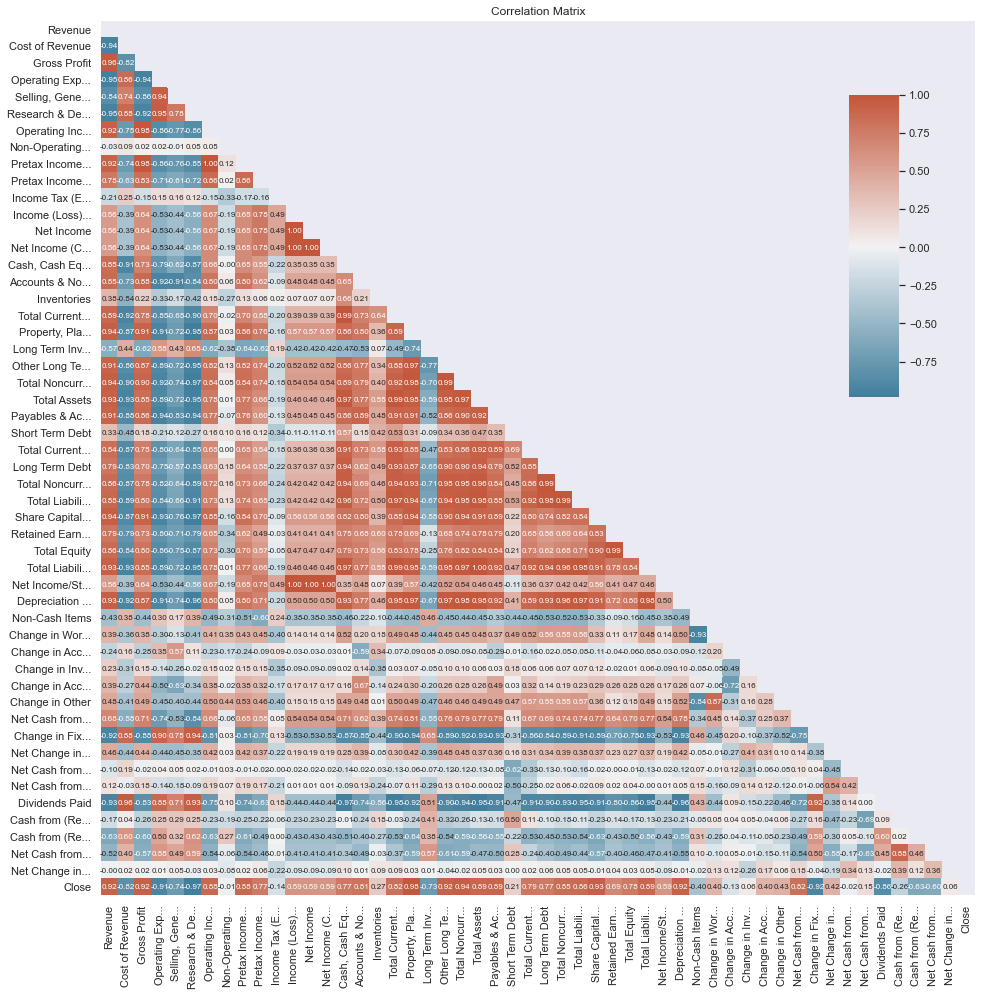

In [54]:
fig, ax = plt.subplots(figsize=(14, 14))
cbar_ax = fig.add_axes([0.85, 0.6, 0.05, 0.3])
ax.set_title('Correlation Matrix')

mask = np.triu(np.ones_like(df.corr()))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_temp.corr(), ax=ax, mask=mask, annot=True, fmt='.2f', 
            annot_kws={'fontsize': 8}, square=True, cmap=cmap,
            cbar_ax=cbar_ax)
plt.tight_layout()

# XGBoost
## Splitting Data

In [8]:
X = df.drop(columns=['Close'])
y = df.Close
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

## XGBRegressor
### Baseline

In [12]:
xgbr = xgboost.XGBRegressor(random_state=42)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
pred_train = xgbr.predict(X_train)
pred_test = xgbr.predict(X_test)
print('Train:', mean_squared_error(y_train, pred_train, squared=False))
print('Test: ', mean_squared_error(y_test, pred_test, squared=False))

Train: 0.0004611875557154188
Test:  17.88745566385804


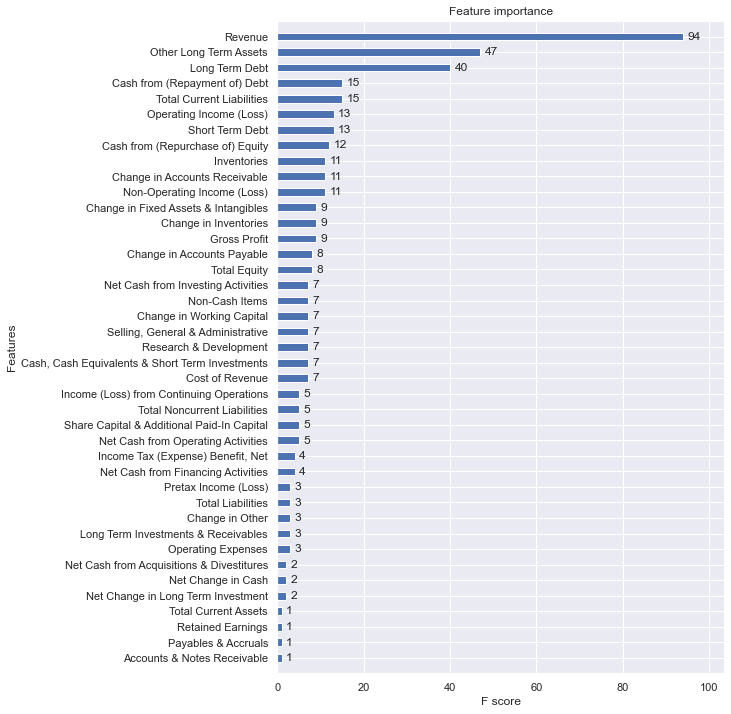

In [22]:
fig, ax = plt.subplots(figsize=(8, 12))
xgboost.plot_importance(xgbr, ax=ax, height=0.5);

### Hyperparameter Tuning

In [27]:
xgbr_params = {'max_depth': [4, 5, 6],
               'colsample_bylevel': [0.2, 0.5, 0.8],
               'colsample_bytree': [0.2, 0.5, 0.8],
               'gamma': [1, 25, 50],
               'learning_rate': [0.05, 0.25, 0.50],
               'random_state': [42]}

In [28]:
xgbr_gs = GridSearchCV(xgbr, param_grid=xgbr_params, n_jobs=-1, verbose=1)
xgbr_gs.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:    8.7s finished


GridSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=0,
                                    num_parallel_tree=1, random_state=42,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
             n_jobs=-1,


In [29]:
pred_train = xgbr_gs.best_estimator_.predict(X_train)
pred_test = xgbr_gs.best_estimator_.predict(X_test)
print('Train:', mean_squared_error(y_train, pred_train, squared=False))
print('Test: ', mean_squared_error(y_test, pred_test, squared=False))

Train: 0.40777501234170577
Test:  13.54018143250952


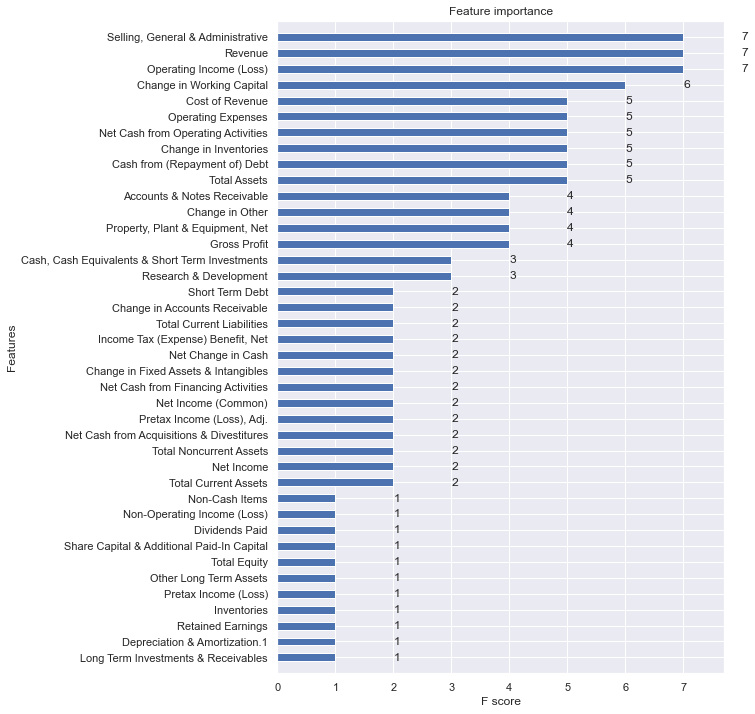

In [30]:
fig, ax = plt.subplots(figsize=(8, 12))
xgboost.plot_importance(xgbr_gs.best_estimator_, ax=ax, height=0.5);

## XGBRFRegressor
### Baseline

In [31]:
xgb_rf = XGBRFRegressor(random_state=42)
xgb_rf.fit(X_train, y_train)

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=100,
               objective='reg:squarederror', random_state=42, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=None)

In [32]:
pred_train = xgb_rf.predict(X_train)
pred_test = xgb_rf.predict(X_test)
print('Train:', mean_squared_error(y_train, pred_train, squared=False))
print('Test: ', mean_squared_error(y_test, pred_test, squared=False))

Train: 3.0717097428906133
Test:  22.617415267400396


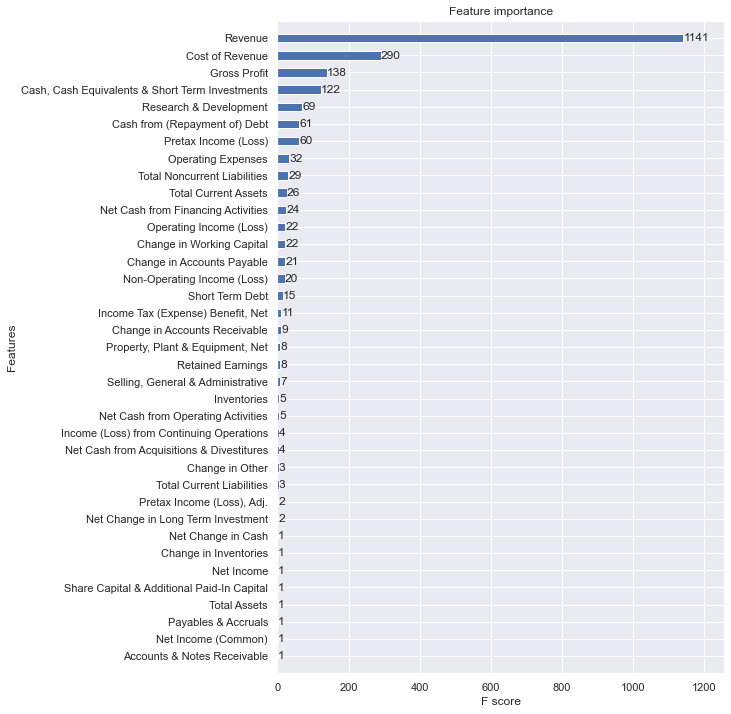

In [33]:
fig, ax = plt.subplots(figsize=(8, 12))
xgboost.plot_importance(xgb_rf, height=0.5, ax=ax);

### Hyperparameter Tuning

In [34]:
xgb_rf_params = {'max_depth': [4, 5, 6],
                 'colsample_bylevel': [0.2, 0.5, 0.8],
                 'colsample_bytree': [0.2, 0.5, 0.8],
                 'gamma': [1, 25, 50],
                 'learning_rate': [0.05, 0.25, 0.50],
                 'random_state': [42]}

In [35]:
xgb_rf_gs = GridSearchCV(xgb_rf, param_grid=xgbr_params, n_jobs=-1, verbose=1)
xgb_rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:    2.3s finished


GridSearchCV(estimator=XGBRFRegressor(base_score=0.5, booster='gbtree',
                                      colsample_bylevel=1, colsample_bytree=1,
                                      gamma=0, gpu_id=-1,
                                      importance_type='gain',
                                      interaction_constraints='',
                                      max_delta_step=0, max_depth=6,
                                      min_child_weight=1, missing=nan,
                                      monotone_constraints='()',
                                      n_estimators=100, n_jobs=0,
                                      num_parallel_tree=100,
                                      objective='reg:squarederror',
                                      random_state=42, reg_alpha=0,
                                      scale_pos_weight=1, tree_method='exact',
                                      validate_parameters=1, verbosity=None),
             n_jobs=-1,
             p

In [36]:
pred_train = xgb_rf_gs.best_estimator_.predict(X_train)
pred_test = xgb_rf_gs.best_estimator_.predict(X_test)
print('Train:', mean_squared_error(y_train, pred_train, squared=False))
print('Test: ', mean_squared_error(y_test, pred_test, squared=False))

Train: 40.52178016697931
Test:  30.713005644677768


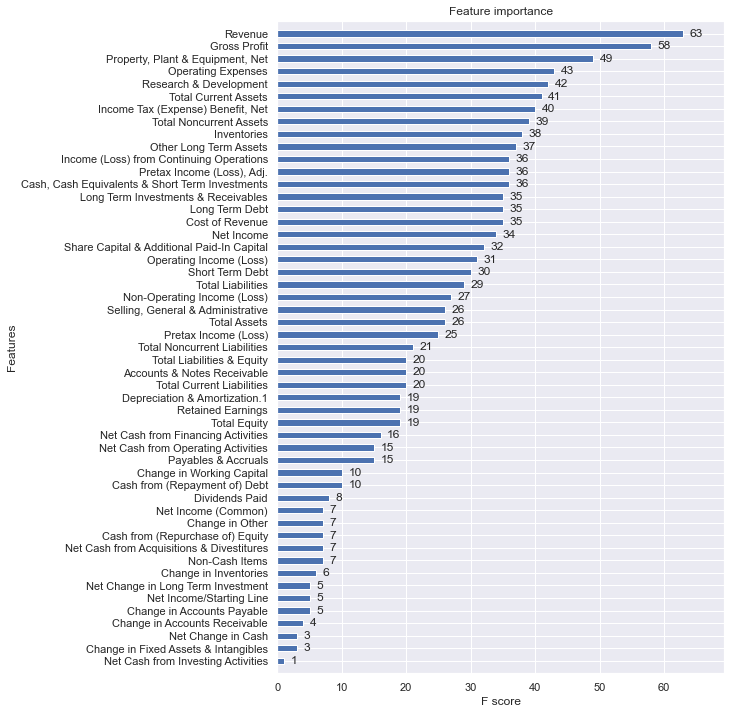

In [37]:
fig, ax = plt.subplots(figsize=(8, 12))
xgboost.plot_importance(xgb_rf_gs.best_estimator_, height=0.5, ax=ax);